# 2. DNA-DSB InDelsTopo Average Analysis

In this notebook we analyze DNA double-strand break (DSB) repair data from [Jeon et al.](https://www.nature.com/articles/s41467-024-51457-9) using the **Insertion Chain Complex**, implemented in the package **InDelsTopo**. We work with the averaged data from four biological replicates per experimental condition, preprocessed in `1_Preprocess_Data.ipynb`.

In the underlying experiments, DSBs are introduced at prescribed positions along a DNA molecule (A, B, AB, or C/D), together with additional experimental modifiers such as RNA orientation (sense/antisense), cellular background (WT/KO), RNase context (R1/R2), RNA structure (branch or branchΔ), and transcriptional activity (presence or absence of a CMV promoter). After repair, DNA sequences are obtained by high-throughput sequencing and aligned to the original reference sequence.

The input data analyzed here consists of frequency tables of repaired DNA sequences (`window_freq_withoutSubst.tsv`), generated using the pipeline of [Channagiri et al.](https://github.com/tchannagiri/DSBplot) and reproduced in the repository of [Jeon et al.](https://github.com/xph9876/RNA-mediated_DSB_repair/). From these data, we isolate the DNA subsequences inserted at the repair site and, for each experimental design, retain only sequences present in all four replicates with an average frequency of at least $10^{-5}$.

The resulting averaged insertion distributions are then used as input for the InDelsTopo analysis.


In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2e}'.format
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from utils.utils import *

from InDelsTopo import Filtration

with open('data/preprocessed/Human_experiments_average.pickle', 'rb') as handle:
    Average_Experiments = pkl.load(handle)

## A. Computing Filtrations and Topological Signatures

We begin by loading the preprocessed data from  
`data/preprocessed/Human_experiments_average.pickle`.

For each averaged experiment, we retain only insertion subsequences with an average frequency of at least $10^{-5}$ and normalize the remaining frequencies so that they sum to 1. Using these normalized distributions, we construct a **filtration of insertion chain complexes** with the `Filtration` object from **InDelsTopo**, up to dimension `max_dim = 10`. The experimental condition associated with each filtration is stored as the attribute `K.exp_name`.

As a topological signature, we compute a **logarithmic Euler characteristic curve** for each filtration. Specifically, we sample `sample_n` values logarithmically in the interval $[10^{-7}, 1]$ and evaluate the Euler characteristic of the filtration at each sampled value. These curves are stored as rows of the data matrix $X$.


In [2]:
sample_n=50
min_threshold=1e-5
max_dim=10

#x-coordinates for computing Euler Curves
xs=np.power(10,np.linspace(-7,0,num=sample_n))

#Create matrix to save Euler Curves, and lists to sava labels and complexes
X=np.zeros((len(Average_Experiments),sample_n))
labels=[]
Filtrations=[]

#Create Complexes and save them
id_exp=0
for Experiment in Average_Experiments:
    exp_name=Experiment['exp_name']
    labels.append(exp_name)
    Table=Experiment['table'].sort_values('avg_freq',ascending=True)

    #Filter by threshold for average frequency
    Table=Table[Table.avg_freq>=min_threshold]

    Words=list(Table.sequence)
    Freqs=np.array(Table.avg_freq)

    #normalize Freqs
    Freqs=Freqs/sum(Freqs)

    #Create Filtration
    K=Filtration()
    K.compute_d_skeleton(Words,Freqs,max_dim)
    K.exp_name=exp_name
    Filtrations.append(K)

    xs,ys=K.get_euler_curve(xs)

    X[id_exp]=ys
    id_exp+=1

Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symb

## B. Hierarchical Clustering and Projection

We perform hierarchical clustering using `AgglomerativeClustering` from `sklearn` with `average` linkage. The resulting hierarchy is visualized as a dendrogram, where each leaf corresponds to an average experiment and is labeled by its experimental design.

The clustering shows an almost clean separation by **DSB break location** (A, B, AB, and C/D). To highlight this structure, experiments are colored according to their break location.

We also visualize the data in two dimensions using **t-SNE**. In the projected space, averaged experiments are again colored by break site, and a clear clustering by break location is observed.

### Conclusion

These results provide further evidence that DNA repair outcomes are influenced by the **local DNA sequence at the break site**. In particular, the topological signatures derived from collections of insertion subsequences cluster according to break position.

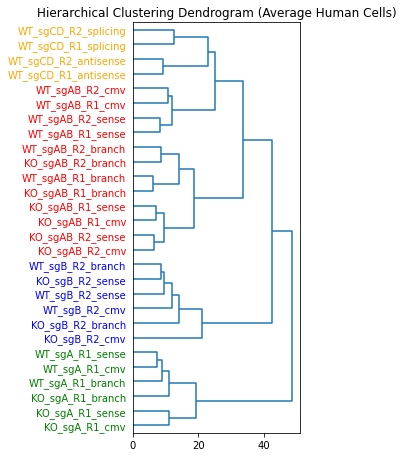

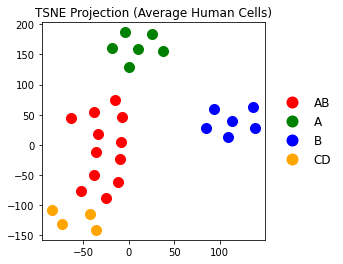

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

#Compute clustering and plot
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='average')
model = model.fit(X)

plt.figure(figsize=(3,15))
plt.title("Hierarchical Clustering Dendrogram (Average Human Cells)")
plot_dendrogram(model, truncate_mode="level",labels=labels,
                leaf_font_size=10)
plt.show()

tSNE=TSNE(metric='euclidean',perplexity=10,n_components=2,random_state=42)
Y=tSNE.fit_transform(X)

plot_projection(Y,labels, figsize=(4,4))
plt.title("TSNE Projection (Average Human Cells)")
plt.show()

## C. Betti Numbers

We computed the homology of the Insertion Chain Complexes for the experiments (at frequency = 1) and report both their Betti numbers and the dimensions of the complexes. We observe:

1. The dimensions of the resulting complexes range from 2 to 4.  
2. Most complexes have more than one connected component ($B_0 > 1$). This is likely due to noise, as random sequences that do not connect to any other sequences contribute no information about the underlying structure.  
3. All but three experiments exhibit no higher-dimensional homology. In the exceptions, only one single 1-dimensional cycle is observed.  

### Conclusions

The minimal dimension of 2 supports our approach of generalizing the Insertion Graph to a higher-dimensional object.  

Theorem 5.12 from (Jonoska, Martinez-Figueroa, Saito) [https://arxiv.org/abs/2509.12607] implies that if we observe most intermediate subsequences between the empty sequence (perfect repair) and the maximal inserted subsequences then all homology should vanish. This is what we expect if insertions occur randomly without bias. Since higher-dimensional homology largely vanishes for our experiments, this provides evidence that insertions are occurring in an unbiased manner.  


In [4]:
#Finally we compute the betti numbers of these Complexes
Table=[]
for label, K in zip(labels,Filtrations):
    betti_numbers=K.get_complex().get_betti_numbers_z2()
    Table.append([label, K.dim]+[safe_get(betti_numbers,i) for i in range(5)])

Table=pd.DataFrame(Table)
Table.columns = ['Experiment', 'Dimension','B_0', 'B_1','B_2','B_3','B_4']
Table

,Experiment,Dimension,B_0,B_1,B_2,B_3,B_4
0,KO_sgAB_R1_branch,3,2,0,0,0,0
1,KO_sgAB_R1_cmv,3,3,1,0,0,0
2,KO_sgAB_R1_sense,3,3,0,0,0,0
3,KO_sgAB_R2_branch,3,1,0,0,0,0
4,KO_sgAB_R2_cmv,3,2,0,0,0,0
5,KO_sgAB_R2_sense,3,3,0,0,0,0
6,KO_sgA_R1_branch,4,1,0,0,0,0
7,KO_sgA_R1_cmv,4,2,0,0,0,0
8,KO_sgA_R1_sense,4,2,0,0,0,0
9,KO_sgB_R2_branch,3,2,0,0,0,0


### D. Understanding the Cycles

We focus on the experiments that exhibit 1-dimensional cycles and compute, using SageMath, a representative cycle for each homology class.  

In all three cases, the cycle has length 4 and is spanned by the vertices:  

$$GACGA, \; GACGAT, \; GACGT, \; GACGTA.$$

Notably, if we add the fifth vertex $GACG$, the cycle disappears. Computing the homology of the complexes after including this vertex confirms that it alone is sufficient to eliminate all higher-dimensional ($\geq 1$) homology.

In [5]:
from InDelsTopo import Chain, Block, Complex
Table1=Table[Table['B_1']>0].sort_values('Experiment')
Indices1=Table1.index
print('Experiments with 1-homology \n ------------------------------\n')
display(Table1)


#Now we look for the generators of the homology
print('Homolgy generators:\n ------------------------------\n')
for index in Indices1:
    K=Filtrations[index]
    CC,ordered_blocks=K.get_complex().get_chain_complex_sage(True)
    gens=CC.homology(generators=True)
    
    cycle_coeffs=gens[1][0][1].vector(1)
    
    cycle_chain = Chain('0', prod_symbol='')
    
    # Combine the 1-dimensional blocks with coefficients
    for c, blk in zip(cycle_coeffs, ordered_blocks[1]):
        cycle_chain += int(c) * blk  # convert Sage integers to Python int

    print(K.exp_name,':\n', cycle_chain)

#We study the result of adding the vertex GACG to the complexes
print('Homology after adding GACG\n ------------------------------\n')
for index in Indices1:
    K=Filtrations[index]
    K2=K.get_complex()
    V=K2[0]
    V=V+[Block('GACG')]
    K3=Complex()
    K3.compute_d_skeleton(V, already_blocks=True)
    print(K.exp_name, ':\n')
    print(K3.get_homology_sage())

Experiments with 1-homology 
 ------------------------------



,Experiment,Dimension,B_0,B_1,B_2,B_3,B_4
1,KO_sgAB_R1_cmv,3,3,1,0,0,0
13,WT_sgAB_R1_cmv,3,6,1,0,0,0
14,WT_sgAB_R1_sense,3,5,1,0,0,0


Homolgy generators:
 ------------------------------

KO_sgAB_R1_cmv :
 GACG(1,A)T + GACG(1,T)A - GACGA(1,T) - GACGT(1,A)
WT_sgAB_R1_cmv :
 GACG(1,A)T + GACG(1,T)A - GACGA(1,T) - GACGT(1,A)
WT_sgAB_R1_sense :
 GACG(1,A)T + GACG(1,T)A - GACGA(1,T) - GACGT(1,A)
Homology after adding GACG
 ------------------------------

Product symbol set to (concatenation)
KO_sgAB_R1_cmv :

{-1: 0, 0: Z x Z, 1: 0, 2: 0, 3: 0}
Product symbol set to (concatenation)
WT_sgAB_R1_cmv :

{-1: 0, 0: Z^5, 1: 0, 2: 0, 3: 0}
Product symbol set to (concatenation)
WT_sgAB_R1_sense :

{-1: 0, 0: Z x Z x Z x Z, 1: 0, 2: 0, 3: 0}


### E. Check Frequencies

For the few experiments in which we observe 1-dimensional homology, the addition of the sequence `'GACG'` eliminates the cycle. We therefore report the average frequencies of the vertices in the generating cycle, as well as the frequency of this particular sequence.  

We observe that `'GACG'` does appear in the experiments, but at an order of magnitude lower frequency than the other vertices, despite being one nucleotide shorter, which would normally make it more likely. This suggests that there may be some bias or structural factor influencing the formation of these cycles, which appear only in experiments at location AB.


In [8]:
vertices=['GACGA', 'GACGAT', 'GACGT', 'GACGTA','GACG' ]
for index in Indices1:
    Experiment=Average_Experiments[index]
    Table=Experiment['table']
    Table=Table[Table.sequence.isin(vertices)]
    print(Experiment['exp_name'])
    display(Table)

KO_sgAB_R1_cmv


library,sequence,yjl237,yjl238,yjl239,yjl240,min_freq,avg_freq
473,GACG,3.01e-06,5.19e-06,1.46e-06,8.50e-07,8.50e-07,2.63e-06
474,GACGA,2.35e-04,2.37e-04,2.34e-04,2.27e-04,2.27e-04,2.33e-04
504,GACGAT,1.24e-05,8.93e-06,8.27e-06,1.43e-05,8.27e-06,1.10e-05
589,GACGT,1.38e-05,1.81e-05,2.77e-05,2.36e-05,1.38e-05,2.08e-05
590,GACGTA,2.39e-05,2.42e-05,2.59e-05,2.92e-05,2.39e-05,2.58e-05


WT_sgAB_R1_cmv


library,sequence,yjl225,yjl226,yjl227,yjl228,min_freq,avg_freq
467,GACG,1.71e-06,3.04e-06,4.17e-06,1.56e-06,1.56e-06,2.62e-06
468,GACGA,3.47e-04,3.59e-04,3.46e-04,3.01e-04,3.01e-04,3.38e-04
495,GACGAT,1.60e-05,1.62e-05,1.20e-05,1.44e-05,1.20e-05,1.47e-05
562,GACGT,3.39e-05,3.87e-05,4.52e-05,4.63e-05,3.39e-05,4.10e-05
563,GACGTA,2.87e-05,2.84e-05,2.96e-05,2.86e-05,2.84e-05,2.88e-05


WT_sgAB_R1_sense


library,sequence,yjl217,yjl218,yjl219,yjl220,min_freq,avg_freq
475,GACG,4.37e-06,2.07e-06,1.36e-06,1.33e-06,1.33e-06,2.28e-06
476,GACGA,3.16e-04,3.31e-04,3.30e-04,2.92e-04,2.92e-04,3.17e-04
511,GACGAT,8.75e-06,1.79e-05,9.05e-06,1.68e-05,8.75e-06,1.31e-05
582,GACGT,3.74e-05,3.63e-05,3.72e-05,3.73e-05,3.63e-05,3.70e-05
583,GACGTA,2.73e-05,2.29e-05,2.17e-05,3.39e-05,2.17e-05,2.65e-05
